In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

The Poisson equation
-----------------------
Imagine a 1D stick being held at a fixed temperature $u=1$ at one end, and $u=0$ at the other. Initially, there will be some variation in temperature, but after some time the rod will reach a steady-state temperature distribution. Identifying the rod with the interval $[0, 1]$, we let $u(x)$ denote the temperature of the rod at the point $x$. A model for heat conduction then gives the equation $$-\frac{\partial^2u} {\partial x^2} = 0$$ with the boundary conditions $u=1$ at $x=0$, and $u=0$ at $x=1$. This equation is called the Poisson equation. It is the "hello world" of scientific computing, and we will go through how this can be solved with the finite element method. The ideas involved in the solution generalise very neatly to complicated equations and higher dimensions, so it is useful to go through it until you understand what is going on. 

For brevity, we write derivatives with a subscript, so the second derivative with respect to $x$ is $u_{xx}$.

 <img src="fig/hotpoker.jpg" alt="Heated rod" style="width: 300px;"/>

FEM discretization (the big picture)
----------------
Before jumping in the mathematical details, let's start with the big picture to explain the finite element discretization:

 <img src="fig/FEM_intro1.png" alt="FEM discr" style="width: 800px;"/>

We can have a look at the previous expression and see how it applies to the first element.

<img src="fig/FEM_intro2.png" alt="Elem discr" style="width: 800px;"/>


FEM discretization (mathematical details)
----------------

First, we choose $N=6$ points uniformly in the domain $\Omega$, of which the first point is $x_0=0$ and the last point is $x_5=1$. 
This gives a subdivision of omega into 5 smaller intervals which we call a *mesh*. Denote the distance between two adjacent mesh points by $h=\frac 1 {N-1}$.
Next, let $V_h$ be the space of piecewise linear functions having "break points" only at the mesh points (nodes).
Two examples of functions in $V_h$ are shown below.

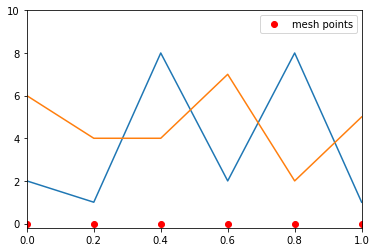

In [2]:
N = 6
h = 1./(N-1)
x = np.linspace(0, 1, N)
plt.plot(x, [0]*N, "ro", label="mesh points")

y1 = [2, 1, 8, 2, 8, 1]
y2 = [6, 4, 4, 7, 2, 5]

plt.plot(x,y1)
plt.plot(x,y2)

plt.xlim(0, 1)
plt.ylim(-0.2, 10)
plt.legend(loc="upper right");

We will try to find a good approximation of the actual solution $u$ in the space $V_h$.
When working with $V_h$, it will be convenient to have a basis for it. 
Let $\phi_i$ be the piecewise linear function which is $0$ at all mesh points except for point $x_i$, where it is $1$. 
Drawing the graph of $\phi_i$, it looks like a "hat". $\phi_0$, ..., $\phi_5$ form a basis of $V_h$ in the mathematical sense.
If you don't know what a basis is, the important thing to note is just that every function in $V_h$ can be written as a sum of $\phi_i$'s in a unique way.

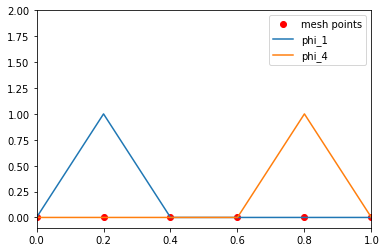

In [3]:
def phi(i):
    y = np.zeros((N))
    y[i] = 1.
    return y

plt.plot(x, [0]*N, "ro", label="mesh points")

for i in [1, 4]:
    plt.plot(x, phi(i), label="phi_{}".format(i))

plt.xlim(0, 1)
plt.ylim(-0.1, 2)
plt.legend(loc="upper right");

Why we need the weak form
----------------------------

What we would like to do now is to say that the solution u is of the form $$u_0 \phi_0 + \ldots + u_5 \phi_5$$ for some unknown numbers $u_0, \ldots, u_5$,  and use the equation we are given ($u_{xx}=0$) to get something we can solve for $u_i$. This would transform our problem, which involves an unknown function $u$, into one which involves unknown *numbers* *

However, the problem with doing so is that our equation involves second derivatives in space, and the functions in $V_h$ have second derivatives which "blow up" at every mesh point because their derivatives are discontinuous there, so their second derivatives are zero everywhere, except at mesh points, where they are infinite. 

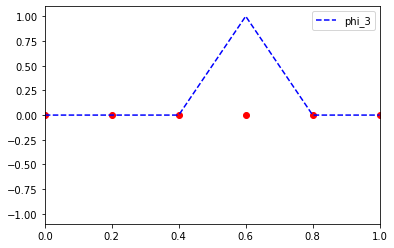

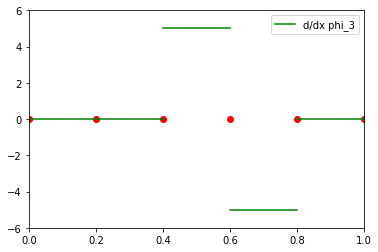

In [4]:
plt.plot(x, N*[0], "ro")
i = 3

plt.plot(x, phi(i), "b--", label="phi_{}".format(i)) 
    
plt.ylim(-1.1, 1.1)
plt.xlim(0, 1)
plt.legend();

plt.figure()

plt.plot(x, N*[0], "ro")
i=3
x1, x2 = x[:i], x[(i+1):]
plt.plot(x1, [0]*x1.shape[0], "g-")
plt.plot(x2, [0]*x2.shape[0], "g-")
plt.plot([x[i-1], x[i]], [1/h, 1/h], "g-", label="d/dx phi_{}".format(i))
plt.plot([x[i], x[i+1]], [-1/h, -1/h], "g-")
    
plt.ylim(-N, N)
plt.xlim(0, 1)
plt.legend();

Finding the weak form
------------------------

Our strategy will be to replace the equation with a different equation which sort of says the same thing, but without using second derivatives. We will call the *weak form* of our equation. To obtain it, take your equation and multiply it by a new function $v$ called a *test function,* giving you $v\cdot u_{xx} = 0$. Then, integrate over the whole domain, giving you the equation $$\int \limits_0^1 v \cdot u_{xx}  \text{dx} = 0$$ 

In some sense this is 'easier' to satisfy than the original equation, because it is possible that $\int \limits_0^1 f  \:
\text{dx} = 0$ even though $f \neq 0$ at every point.However, it is possible to show that, roughly speaking, if the integral equation is true for _every_ function $v$, then the original equation must be true as well, so requiring the latter equation to hold for _all_ $v$ gives us something equivalent to the original equation. (For an idea of why this is true, think about what happens when $v$ is a very narrow 'bump' function which is approximately 1 near some point, 
and rapidly decays to 0 outside that point.)

Now, this equation still involves second derivatives of $u$. However, using integration by parts, we can "move" some derivatives to v as well. Because $$(v \cdot u_x)_x = v_x \cdot u_x + v \cdot u_{xx}$$
we get the equation $$0 = \int\limits_0^1 v \cdot u_{xx} \: \text{dx}= \int\limits_0^1 (v \cdot u_x)_x \: \text{dx} - \int\limits_0^1 v_x \cdot u_x \: \text{dx} = v(1)u_x(1) - v(0) u_x(0) - \int\limits_0^1 v_x \cdot u_x \: \text{dx}$$

And this is an equation with only first derivatives!
While the derivative has a jump discontinuity at the nodes, this is not a problem because the value of a function at a single point doesn't affect its integral. So to summarize, we have shown that our original equation $u_{xx} = 0$ is in some sense equivalent to finding a $u$ which satisfies $$v(1)u_x(1) - v(0) u_x(0) - \int\limits_0^1 v_x \cdot u_x \: \text{dx}= 0$$ for all functions $v$. 
We call the original equation the _strong form_, and the new equation the _weak form_. 

Building a system of linear equations from the weak form
----------------------------------------------------------------
Now we can carry through our original plan of setting $u = \sum_i u_i \phi_i$ and building a system of equations to solve for the real numbers $u_i$. 

Since the function $v$ can be arbitrary defined, let's use $v = \phi_j$ for $j = 0,...,5$ ,so our equation becomes: $$- \int\limits_0^1(\phi_j)_x \cdot \sum_i u_i (\phi_i)_x \: \text{dx}= 0$$ or equivalently $$\sum_i u_i \int\limits_0^1 (\phi_i)_x \cdot (\phi_j)_x \: \text{dx} = 0$$

Because $\phi_i$, $\phi_j$ are known functions, we see that if we first compute the quantities $\int\limits_0^1 (\phi_i)_x \cdot (\phi_j)_x \: \text{dx} = 0$ for all pairs $i,j$, this will be a nice system of linear equations
in real numbers that we can solve. We also see that $(\phi_i)_x \cdot (\phi_j)_x$ is fairly easy to compute. To demonstrate this, let's consider the assembly of the system over the fisr element of our mesh.  

<img src="fig/FEM_intro3.png" alt="FEM discr" style="width: 800px;"/>


Form the calculation above, we have assembled only one piece of the problem, corresponding from the contribution of the first element of the mesh to the two first nodes. In order to assemble the global system of equation, the operation must be repeated for each elements. Each entry of the elementary matrices must be added to the global matrix. 

After a special treatment for the boundary conditions, that we strongly impose to be $u_0=1$ at $x_0=0$ and $u_5=0$ at $x_5=1$, we obtain:   




 $$\begin{bmatrix}
    1 & 0 & 0 & 0 & 0 & 0 \\
    -\frac 1 h & \frac 2h & - \frac 1h & 0 & 0 & 0\\
    0 & -\frac 1 h & \frac 2h & - \frac 1h & 0 & 0 \\
    0 & 0 & -\frac 1 h & \frac 2h & - \frac 1h & 0 \\
    0 & 0 & 0 & -\frac 1 h & \frac 2h & - \frac 1h \\
    0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}\begin{bmatrix}
    u_0 \\[2.2pt]
    u_1 \\[2.2pt]
    u_2 \\[2.2pt]
    u_3 \\[2.2pt]
    u_4 \\[2.2pt]
    u_5
\end{bmatrix} = \begin{bmatrix}
    1 \\[2.2pt]
    0 \\[2.2pt]
    0 \\[2.2pt]
    0 \\[2.2pt]
    0 \\[2.2pt]
    0
\end{bmatrix}$$

Notice that this system is *sparse* in the sense that the equation you get for $v=\phi_i$ only has 3 unknowns: $u_{i-1}, u_i$ and $u_{i+1}$, and that this would be true even if $N$ was a much larger number than 6. This sparsity comes from the fact that the $\phi_i$ are very 'local' functions. Though we will not go into details here, this locality is really what makes the finite element method so useful, as a sparse system of equations is a lot easier to solve numerically than a dense one. Writing our system in matrix form, we get:
Feel free to multiply out the above to see that we in fact get the equations we wrote down previously.


Solving the system of linear equations
-------------------------------------------
In any case, this can now be packaged up and handed over to whichever linear algebra software you prefer.
Then, once the $u_i$ have been found, our approximation of the solution u is then the function $\sum_i u_i \phi_i(x)$. Below, we do this in numpy:


In [7]:
H = 1/h
A = np.array(([
    [1, 0, 0, 0, 0, 0],
    [-H, 2*H, -H, 0, 0, 0],
    [0, -H, 2*H, -H, 0, 0],
    [0, 0, -H, 2*H, -H, 0],
    [0, 0, 0, -H, 2*H, -H],
    [0, 0, 0, 0, 0, 1],
    
]))

b = np.array([1, 0, 0, 0, 0, 0])

u = np.linalg.solve(A, b)
print(u)

[1.  0.8 0.6 0.4 0.2 0. ]


So the solution is $$u = \begin{bmatrix}
    1 \\
    0.8 \\
    0.6 \\
    0.4 \\
    0.2 \\
    0
\end{bmatrix}$$

To see what this looks like as a function of $x$, we recall that $u_i$ were defined so that $u(x) = \sum_i u_i \phi_i(x)$. Substituting in our solution $u_i$, we see that $u$ looks like the below:



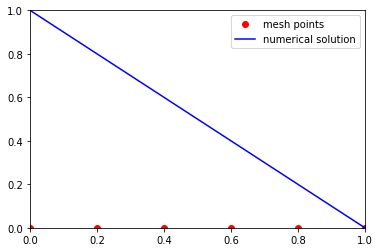

In [6]:
U = np.zeros((N))
for i in range(N):
    U += u[i]*phi(i)
    
plt.plot(x, [0]*N, "ro", label="mesh points")
plt.plot(x, U, "b-", label="numerical solution")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend();

We see that in this case we get a very nice and linear solution $u(x) = 1-x$. Because $u_{xx}=0$ and the boundary conditions are satisfied, this is actually the real solution of the equation.

Summary
--------
To recap the method used:

1. Take the original equation, multiply it by a test function v and integrate by parts to get rid of all second derivatives
2. Choose some basis functions $\phi_i$, write $u=\sum_i u_i \phi_i$ and put $v = \phi_0, \phi_1, \phi_2$ successively to get a bunch of equations
3. Express the resulting equations in terms of known stuff with $\phi_i$, build a linear system of equations and solve it for the unknowns $u_i$
4. The solution $u(x)$ is then approximated as $\sum_i u_i \phi_i(x)$

This is the finite element method. It can also be used to solve more complicated PDEs, handle different basis functions $\phi_i$, work with more complicated domains $\Omega$ and more, without significant deviations from the above list. In future lectures, we will give examples of the method applied to more exciting equations and demonstrate how to use *FEniCS*, a software suite.


Exercises
---------------------

1. Repeat the procedure outlined here for the equation $u_{xx} + u = 0$. If you want, let the number of mesh points $n$ be arbitrary, otherwise just use 5. What does the system of equations look like?

2. The boundary condition $u=0$ at $x=0$ corresponds to fixing the temperature of the rod at the end $x=0$. What do you think the condition $u_x = 0$ would represent? Can it be incorporated into the system of equations somehow?

3. If we instead of having one equation with one unknown function had two equations with two unknown functions, could you still apply the finite element method? How?